In [1]:
## the data directory
datadir = '../../Datasets/'

## location of the GED code
## use the '-S' option to use split JS divergence
GED = 'C:/src/DS_8014/GraphMiningNotebooks/GED/GED.exe'

curr_dir = 'C:/src/DS_8014/GraphMiningNotebooks/Python_Notebooks/Assignments/'
## location of the node2vec code
n2v = 'C:/src/DS_8014/GraphMiningNotebooks/node2vec.exe'

abcd_path = '/c/src/DS_8014/ABCDGraphGenerator.jl/utils/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
import scipy.sparse.linalg as lg
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score as AMI
from graphrole import RecursiveFeatureExtractor, RoleExtractor
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score as CHS
from sklearn.metrics import silhouette_score as SIL
%config Completer.use_jedi = False

## node and edge greyscale colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

c:\src\DS_8014\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# A few useful functions

In [3]:
## as defined in the node2vec paper
def binary_operator(u, v, op='had'):
    if op=='had':
        return u * v
    if op=='l1':
        return np.abs(u - v)
    if op=='l2':
        return (u - v) ** 2
    if op=='avg':
        return (u + v) / 2.0

## 'N2K' mapping is used to map between node name and key value in graph when reading results from node2vec
def readEmbedding(fn="_embed", N2K=None):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    if N2K!=None:
        x = [N2K[i] for i in D[0]]
        D[0] = x    
        D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    return Y

## Read embedding from file in node2vec format
## Map to layout format
## for visualization, we use UMAP if dim > 2
def embed2layout(fn="_embed"):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    if Y.shape[1]>2:
        Y = umap.UMAP().fit_transform(Y)
    ly = []
    for v in range(Y.shape[0]):
        ly.append((Y[v][0],Y[v][1]))
    return ly


## Computing JS divergence with GED code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, entropy=False, debug=False):
    if entropy:
        x = GED+' -E -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    else:
        x = GED+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file        
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)

    if debug:
        print(s)
        
    x = s.stdout.decode().split(' ')    
    div = float(x[1])
    return(div)


## Hope embedding with various similarity functions
def Hope(g, sim='katz', dim=2, verbose=False, beta=.01, alpha=.5):
    ## For undirected graphs, embedding as source and target are identical
    if g.is_directed() == False:
        dim = dim*2
    A = np.array(g.get_adjacency().data)
    beta = beta
    alpha = alpha
    n = g.vcount()
    ## Katz
    if sim == 'katz':
        M_g = np.eye(n) - beta * A
        M_l = beta * A
    ## Adamic-Adar
    if sim == 'aa':
        M_g = np.eye(n)
        ## fix bug 1/x and take log();
        D = np.diag([1/np.log(x) if x>1 else 0 for x in g.degree()]) 
        # D = np.diag([1/np.log(max(2,x)) for x in g.degree()]) 
        M_l = np.dot(np.dot(A,D),A)
        np.fill_diagonal(M_l,0)
    ## Common neighbors
    if sim == 'cn':
        M_g = np.eye(n)
        M_l = np.dot(A,A)
    ## presonalized page rank
    if sim == 'ppr':
        P = []
        for i in range(n):
            s = np.sum(A[i])
            if s>0:
                P.append([x/s for x in A[i]])
            else:
                P.append([1/n for x in A[i]])
        P = np.transpose(np.array(P)) ## fix bug - take transpose
        M_g = np.eye(n)-alpha*P
        M_l = (1-alpha)*np.eye(n)
    S = np.dot(np.linalg.inv(M_g), M_l)
    u, s, vt = lg.svds(S, k=dim // 2) #########################
    X1 = np.dot(u, np.diag(np.sqrt(s)))
    X2 = np.dot(vt.T, np.diag(np.sqrt(s)))
    X = np.concatenate((X1, X2), axis=1)
    p_d_p_t = np.dot(u, np.dot(np.diag(s), vt))
    eig_err = np.linalg.norm(p_d_p_t - S)
    if verbose:
        print('SVD error (low rank): %f' % eig_err)
    ## undirected graphs have identical source and target embeddings
    if g.is_directed() == False:
        d = dim//2
        return X[:,:d]
    else:
        return X

## save to disk to compute divergence
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(g.vs[i]['name']+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')

## Laplacian eigenmaps embedding
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM') ####################
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

## Returns a LaTeX bmatrix
def bmatrix(a):
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [4]:
def generate_abcd(n, gamma, tau, min_degree, max_degree, min_community, max_community, mixing_parameter, name_suffix):
    abcd_path = "C:/src/DS_8014/ABCDGraphGenerator.jl/utils/"
    output_path = "C:/src/DS_8014/GraphMiningNotebooks/Python_Notebooks/Assignments/"
    cmd = f'julia {abcd_path}deg_sampler.jl {output_path}deg_{name_suffix}.dat {gamma} {min_degree} {max_degree} {n} {n}'
    #print(cmd)
    os.system(cmd)
    cmd = f'julia {abcd_path}com_sampler.jl {output_path}cs_{name_suffix}.dat {tau} {min_community} {max_community} ' + str(n) + ' ' + str(n)
    os.system(cmd)
    #print(cmd)
    xi = mixing_parameter
    cmd = f'julia {abcd_path}graph_sampler.jl {output_path}net_{name_suffix}.dat {output_path}comm_{name_suffix}.dat {output_path}deg_{name_suffix}.dat {output_path}cs_{name_suffix}.dat xi {xi} false false'
    os.system(cmd)

    comm_file_name = f"{output_path}comm_{name_suffix}.dat"
    x = pd.read_csv(comm_file_name, sep="\t", header=None)
    community = pd.DataFrame(x[1] - 1)
    community.to_csv(f"{output_path}comm_{name_suffix}.ecg", index=False, header=None)

    #print(cmd)
    g = ig.Graph.Read_Ncol(f'{output_path}net_{name_suffix}.dat',directed=False)
    c = np.loadtxt(f'{output_path}comm_{name_suffix}.dat',dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(x['name'])-1]-1 for x in g.vs]
    print('number of communities:',np.max(gt)+1)
    g.vs["comm"] = gt
    return g

In [4]:
def sort_and_save_embedding(x, g, fn="_embed", reindex = False):
    df = pd.DataFrame(x)    
    df.insert(0, "node", [int(x) for x in g.vs["name"]]) 
    df = df.sort_values(by="node", ascending=True)
    df["node"] = df["node"] - 1

    if reindex:
        new_indices = np.arange(stop=len(g.vs))
        df["node"] = new_indices

    df.head()        
    np_array = df.to_numpy()
    with open(fn,'w') as f:
        f.write(str(np_array.shape[0]) + " " + str(np_array.shape[1] - 1)+'\n')
        for i in range(np_array.shape[0]):
                f.write(str(int(np_array[i][0]))+' ')
                for j in range(np_array.shape[1] - 1):
                    f.write(str(np_array[i][j+1])+' ')
                f.write('\n')

#X = Hope(g,sim='katz',dim=4)
#sort_and_save_embedding(X, g, "_embed_sorted")

# Q1

In [5]:
n=1000
g = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=5, max_degree=50, min_community=75, max_community=150, mixing_parameter=0.2, name_suffix="Q1_GRAPH")
g.write_edgelist("Q1_ABCD.edgelist")

number of communities: 9


In [ ]:
L = [] ## to store results
DIM = [4, 8, 16, 32, 64, 128]  ## try embedding in different dimensions
best_jsd = 1    ## keep track of best JS-divergence
worst_jsd = 0   ## and worst one.
sim = "katz"
## Hope with different choices for the similarity
for dim in DIM:
    
    X = Hope(g, sim=sim, dim=dim)
    df = pd.DataFrame(X)
    df.insert(0, "node", [int(x) for x in g.vs["name"]]) 
    df = df.sort_values(by="node", ascending=True)
    embed_path = f'{curr_dir}Q1_HOPE_embeddings/_embed_dim={dim}'
    sort_and_save_embedding(X,g, fn=embed_path)
        
    jsd = JS(f'{curr_dir}Q1_ABCD.edgelist',f'{curr_dir}comm_Q1_GRAPH.ecg', '{embed_path}', debug=False)
    #jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
    ## keep track of best and worst embeddings
    if jsd < best_jsd:
        os.system('cp _embed _embed_best')
        best_jsd = jsd
    if jsd > worst_jsd:
        os.system('cp _embed _embed_worst')
        worst_jsd = jsd
    L.append([dim,'hope',sim,jsd,0]) #0 = iteration number, 0 for deterministic algorithms as iteration isn't necessary
    
## node2vec 
## we try a few choices for p and q, parameters for the random walks
## on some platforms, we got better results with longer random walks (code commented out below)
p = 1
q = 1
iterations = 30
for dim in DIM:
    for i in range(iterations):
        print(f"dimension {dim} Iteration {i}")        
        x = f'{n2v} -l:10 -i:{curr_dir}Q1_ABCD.edgelist -o:{curr_dir}Q1_node2vec_embedding/_embed_node2vec_dim={dim}_{i} -d:{str(dim)} -p:{str(p)} -q:{str(q)}'
        print(x)        
        r = os.system(x)
        jsd = JS(f'{curr_dir}Q1_ABCD.edgelist',f'{curr_dir}comm_Q1_GRAPH.ecg',f'{curr_dir}Q1_node2vec_embedding/_embed_node2vec_dim={dim}_{i}', debug=False)

        ## keep track of best and worst embeddings
        if jsd < best_jsd:
            os.system('cp _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst')
            worst_jsd = jsd
        
        ## store results
        L.append([dim,'n2v',str(p)+' '+str(q),jsd, i])

## store results in dataframe, show top results w.r.t. JS divergence (lower is better)        
D = pd.DataFrame(L,columns=['dim','algo','param','jsd', 'iteration'])
D = D.sort_values(by=['dim', 'iteration'],axis=0)
D.head()
D.to_csv('q1.csv')

In [27]:
D.to_csv('q1.csv')

In [5]:
D = pd.read_csv('q1.csv').drop('Unnamed: 0', axis=1)
mean = D.groupby(["algo", "dim"]).mean(numeric_only=True).drop('iteration', axis=1)
print("MEAN JSD SCORES")
mean.head(20)

MEAN JSD SCORES


jsd
algo dim          
hope 4    0.001325
     8    0.001325
     16   0.001325
     32   0.001325
     64   0.001325
     128  0.001325
n2v  4    0.001269
     8    0.001254
     16   0.001255
     32   0.001259
     64   0.001275
     128  0.001291

In [6]:
std = D.groupby(["algo", "dim"]).std(numeric_only=True).drop('iteration', axis=1)
print(f"JSD STD DEVIATION")
std.head(20)

JSD STD DEVIATION


jsd
algo dim          
hope 4         NaN
     8         NaN
     16        NaN
     32        NaN
     64        NaN
     128       NaN
n2v  4    0.000032
     8    0.000019
     16   0.000019
     32   0.000020
     64   0.000018
     128  0.000013

According to the table, for node2vec, the 128 embedding algorithm was the most stable, and produced the best results. For the HOPE algorithm, all results are stable as it is a deterministic algorithm, and all embeddings performed equally well.

 # Q2

In [43]:
g = ig.Graph.Read_Ncol(f'net_Q1_GRAPH.dat',directed=False)
c = np.loadtxt(f'comm_Q1_GRAPH.dat',dtype='uint16',usecols=(1))
## ground-truth communities
gt = [c[int(x['name'])-1]-1 for x in g.vs]
print('number of communities:',np.max(gt)+1)
g.vs["comm"] = gt

Q2 = pd.read_csv('q1.csv')
Q2 = Q2.sort_values(by="jsd", ascending=False)
print(Q2.head(1))
print(Q2.tail(1))

number of communities: 9
   Unnamed: 0  dim  algo param       jsd  iteration
0           0    4  hope  katz  0.001325          0
    Unnamed: 0  dim algo param       jsd  iteration
27          32    4  n2v   1 1  0.001183         26


In [37]:
#Best is HOPE with 4 embedding/Hope in general
#Worst is node2vec with 4 embedding, iteration 26
best_embedding = readEmbedding(fn="Q1_HOPE_embeddings/_embed_dim=4")
worst_embedding = readEmbedding(fn="Q1_node2vec_embedding/_embed_node2vec_dim=4_26")

In [44]:
from sklearn.metrics import adjusted_rand_score as ARI

ABCD = g
k = np.max(gt)+1 #Should be 9
GT = {k:(v-1) for k,v in enumerate(ABCD.vs['comm'])}
best_cl = KMeans(n_clusters=k).fit(best_embedding)
worst_cl = KMeans(n_clusters=k).fit(worst_embedding)
best_d = {k:v for k,v in enumerate(best_cl.labels_)}
worst_d = {k:v for k,v in enumerate(worst_cl.labels_)}

best_ami = AMI(list(GT.values()),list(best_d.values())) ## AMI vs ground truth
worst_ami = AMI(list(GT.values()),list(worst_d.values())) ## AMI vs ground truth
print(f"Best AMI: {best_ami}")
print(f"Worst AMI: {worst_ami}")

best_ari = ARI(list(GT.values()),list(best_d.values()))
worst_ari = ARI(list(GT.values()),list(worst_d.values()))

print(f"Best ARI: {best_ari}")
print(f"Worst ARI: {worst_ari}")

c = np.loadtxt('comm_Q1_GRAPH.dat',dtype='uint16',usecols=(1))
gt = [c[int(x['name'])-1]-1 for x in g.vs]
tc = {idx:part for idx,part in enumerate(gt)}

best_agri = ABCD.gam(tc,best_d)
worst_agri = ABCD.gam(tc,worst_d)

print(f"Best AGRI: {best_agri}")
print(f"Worst AGRI: {worst_agri}")

Best AMI: 0.03596824728007377
Worst AMI: 0.01820837036625034
Best ARI: 0.00950631016216057
Worst ARI: 0.007828979387929353
Best AGRI: 0.014766322458694492
Worst AGRI: 0.007759800919277597


# Q3

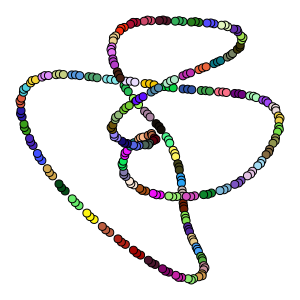

In [20]:
## n cliques of size s
#colours = []
from random import randint


#colours = ['red', 'blue', 'green', 'black', 'gray', 'pink', 'purple', 'brown', 'aqua', 'yellow']
## n cliques of size s
def ringOfCliques(n,s,edgelist_file,comm_file):
    colours = []
    for i in range(n+1):
        colours.append('#%06X' % randint(0, 0xFFFFFF))

    roc = ig.Graph.Erdos_Renyi(n=n*s,p=0)
    ## cliques
    community_list = []
    for i in range(n):
        for j in np.arange(s*i,s*(i+1)):
            for k in np.arange(j+1,s*(i+1)):
                roc.add_edge(j,k)

            roc.vs[j]['color'] = colours[i]
            roc.vs[j]['name'] = i + 1
            community_list.append(str(i))
            
    ## ring
    for i in range(n):
        if i>0:
            roc.add_edge(s*i-1,s*i)
        else:
            roc.add_edge(n*s-1,0)
    roc.vs['size'] = 8
    #roc.vs['color'] = cls[2]
    roc.es['color'] = cls_edges

    roc.write_edgelist("Q3.edgelist")

    with open(comm_file,'w') as f:
        for comm in community_list:
            f.write(comm + "\n")

    colour_file = 'roc_colour.txt'
    with open(colour_file,'w') as f:
        for node in roc.vs:
            f.write(node['color'] + "\n")

    return roc

## Assume 100 3-cliques as it is not stated in question and using the values for 5.11 means we cannot generate embeddings for dimensions greater than 30
# 300 nodes is double our max embedding dimension rounded up to the nearest hundred
#roc = ringOfCliques(10,3, "Q3.edgelist", "Q3_comm.ecg")
roc = ringOfCliques(100,3, "Q3.edgelist", "Q3_comm.ecg")
ig.plot(roc,bbox=(0,0,300,300))



In [7]:
def run_HOPE_and_node2vec(g, hope_embedding_dir, node2vec_dir, edgelist_file, community_file, output_file, DIM, debug=False, reindex=False):

    L = [] ## to store results    
    best_jsd = 1    ## keep track of best JS-divergence
    worst_jsd = 0   ## and worst one.
    sim = "katz"
    ## Hope with different choices for the similarity
    for dim in DIM:
        
        X = Hope(g, sim=sim, dim=dim)
        df = pd.DataFrame(X)
        df.insert(0, "node", [int(x) for x in g.vs["name"]]) 
        df = df.sort_values(by="node", ascending=True)
        embed_path = f'{curr_dir}{hope_embedding_dir}/_embed_dim={dim}'
        sort_and_save_embedding(X,g, fn=embed_path, reindex=reindex)
            
        jsd = JS(f'{curr_dir}{edgelist_file}',f'{curr_dir}{community_file}', f'{embed_path}', debug=debug)
        #jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
        ## keep track of best and worst embeddings
        if jsd < best_jsd:
            os.system('cp _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst')
            worst_jsd = jsd
        L.append([dim,'hope',sim,jsd,0]) #0 = iteration number, 0 for deterministic algorithms as iteration isn't necessary

        #Append at end of each iteration
        D = pd.DataFrame(L,columns=['dim','algo','param','jsd', 'iteration'])
        D = D.sort_values(by=['dim', 'iteration'],axis=0)
        D.head()
        D.to_csv(output_file)
        
    ## node2vec 
    ## we try a few choices for p and q, parameters for the random walks
    ## on some platforms, we got better results with longer random walks (code commented out below)
    p = 1
    q = 1
    iterations = 1
    for dim in DIM:
        for i in range(iterations):
            print(f"dimension {dim} Iteration {i}")        
            x = f'{n2v} -l:10 -i:{curr_dir}{edgelist_file} -o:{curr_dir}{node2vec_dir}/_embed_node2vec_dim={dim}_{i} -d:{str(dim)} -p:{str(p)} -q:{str(q)}'
            #print(x)        
            r = os.system(x)
            embed_path = f'{curr_dir}{node2vec_dir}/_embed_node2vec_dim={dim}_{i}'
            jsd = JS(f'{curr_dir}{edgelist_file}',f'{curr_dir}{community_file}', f'{embed_path}', debug=debug)

            ## keep track of best and worst embeddings
            if jsd < best_jsd:
                os.system('cp _embed _embed_best')
                best_jsd = jsd
            if jsd > worst_jsd:
                os.system('cp _embed _embed_worst')
                worst_jsd = jsd
            
            ## store results
            L.append([dim,'n2v',str(p)+' '+str(q),jsd, i])

            #Append at end of each iteration
            D = pd.DataFrame(L,columns=['dim','algo','param','jsd', 'iteration'])
            D = D.sort_values(by=['dim', 'iteration'],axis=0)
            D.head()
            D.to_csv(output_file)

    ## store results in dataframe, show top results w.r.t. JS divergence (lower is better)        
    D = pd.DataFrame(L,columns=['dim','algo','param','jsd', 'iteration'])
    D = D.sort_values(by=['dim', 'iteration'],axis=0)
    D.head()
    D.to_csv(output_file)
    return D

In [ ]:
DIM = [4, 8, 16, 32, 64, 128]  ## try embedding in different dimensions
result_df = run_HOPE_and_node2vec(roc, "Q3_HOPE_embeddings", "Q3_node2vec_embeddings", "Q3.edgelist", "Q3_comm.ecg", 'q3.csv', DIM)

In [24]:
result_df = pd.read_csv('q3.csv')
result_df = result_df.sort_values(by='jsd', ascending=False)
print(result_df.head(1))
print(result_df.tail(1))

    dim  algo param       jsd  iteration
0     4  hope  katz  0.008686          0
29    4   n2v   1 1  0.008601         23
27    4   n2v   1 1  0.008601         21
26    4   n2v   1 1  0.008601         20
7     4   n2v   1 1  0.008601          1
8     4   n2v   1 1  0.008601          2
9     4   n2v   1 1  0.008601          3
10    4   n2v   1 1  0.008601          4
11    4   n2v   1 1  0.008601          5
12    4   n2v   1 1  0.008601          6
   dim  algo param       jsd  iteration
3   32  hope  katz  0.007798          0


In [25]:
q3_best_embedding = readEmbedding(fn="Q3_HOPE_embeddings/_embed_dim=4")
#q3_worst_embedding = readEmbedding(fn="Q3_node2vec_embeddings/_embed_node2vec_dim=32_0")
q3_worst_embedding = readEmbedding(fn="Q3_HOPE_embeddings/_embed_dim=32")
dim = 2
U_best = umap.UMAP(n_components=dim).fit_transform(q3_best_embedding)
U_worst = umap.UMAP(n_components=dim).fit_transform(q3_worst_embedding)

Text(0.5, 1.0, 'Best embedding scatter plot (reduced to two dimensions)')

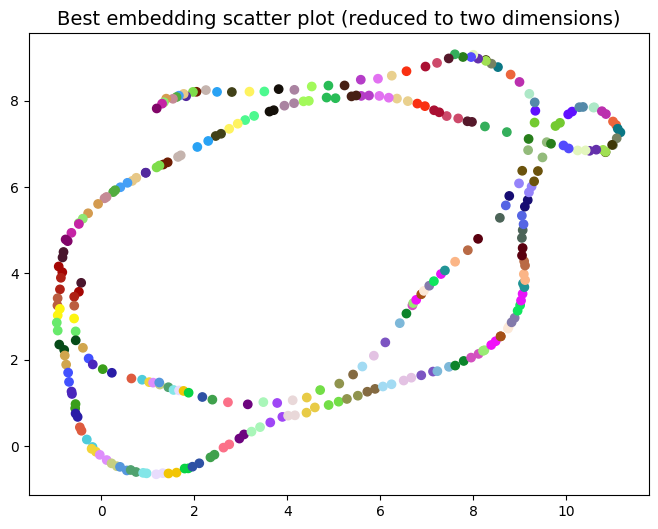

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(x = U_best[:,0], y = U_best[:,1], c = roc.vs['color'], marker='o',label='Best Embedding')
plt.title('Best embedding scatter plot (reduced to two dimensions)', fontsize=14)

Text(0.5, 1.0, 'Worst embedding scatter plot (reduced to two dimensions)')

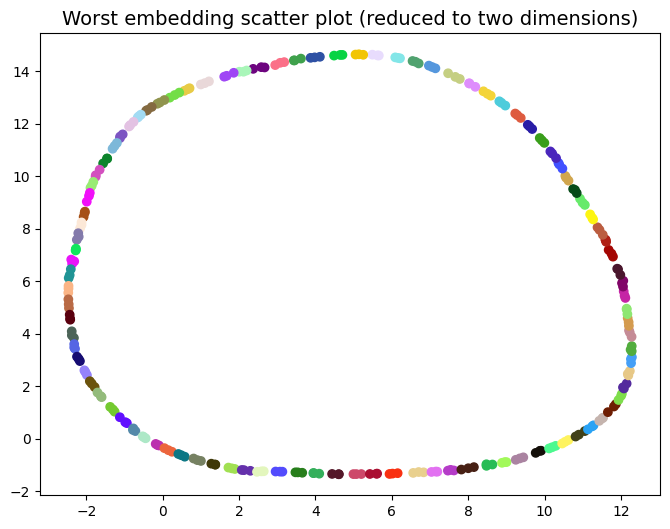

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(x = U_worst[:,0], y = U_worst[:,1],marker='o',c = roc.vs['color'],label='Worst Embedding')
plt.title('Worst embedding scatter plot (reduced to two dimensions)', fontsize=14)

# Q4 

## Repeat Experiment

In [58]:
from random import randint

## read edge list for the grid network and build undirected graph
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some of the attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] ## tuples with lat/lon
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

subgr = gr.clusters().giant().copy()

colours = []

for i in range(500):
    colours.append('#%06X' % randint(0, 0xFFFFFF))

ecg = subgr.community_ecg()
subgr.vs['gn'] = ecg.membership
cls = colours
subgr.vs['color'] = [cls[i] for i in subgr.vs['gn']]


C:\Users\vince\AppData\Local\Temp\ipykernel_25556\4063493004.py:22: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  subgr = gr.clusters().giant().copy()


In [59]:
#Reindex subgraph

name_list = list()
for node in subgr.vs:
    name_list.append(int(node['name']))

sorted_namelist = np.sort(name_list)

remap_dict = dict()
for i in range(len(sorted_namelist)):
    remap_dict[str(sorted_namelist[i])] = i+1

for node in subgr.vs:
    node['name'] = remap_dict[node['name']] 

# test_list = list()
# for node in subgr.vs:
#     test_list.append(node['name'])
# print(np.sort(test_list))

In [ ]:
#Repeat experiment, had to run in batches because kernel would crash if program ran for more than an hour ish. Each js score took about 25 minutes to compute, so only did 1 iteration for each embedding

#DIM = [4, 8, 16, 32, 64, 128]  ## try embedding in different dimensions
DIM = [64, 128]
result_df = run_HOPE_and_node2vec(subgr, "Q4_HOPE_embeddings", "Q4_node2vec_embeddings", "Q4.edgelist", "Q4_comm.ecg", 'q4.csv', DIM, debug=True, reindex=False)

In [9]:
#Get best and worst embedding

result_df = pd.read_csv('q4.csv')
result_df = result_df.sort_values(by='jsd', ascending=False)
print(result_df.head(1))
print(result_df.tail(1))

   Unnamed: 0  dim  algo param       jsd  iteration
5           6  128  hope  katz  0.161421          0
   Unnamed: 0  dim algo param       jsd  iteration
9          10   64  n2v   1 1  0.084769          0


In [10]:
q4_best_embedding = readEmbedding(fn="Q4_HOPE_embeddings/_embed_dim=128")
#q3_worst_embedding = readEmbedding(fn="Q3_node2vec_embeddings/_embed_node2vec_dim=32_0")
q4_worst_embedding = readEmbedding(fn="Q4_node2vec_embeddings/_embed_node2vec_dim=64_0")
dim = 2
U_best = umap.UMAP(n_components=dim).fit_transform(q4_best_embedding)
U_worst = umap.UMAP(n_components=dim).fit_transform(q4_worst_embedding)

Text(0.5, 1.0, 'Q4 Best embedding scatter plot (reduced to two dimensions)')

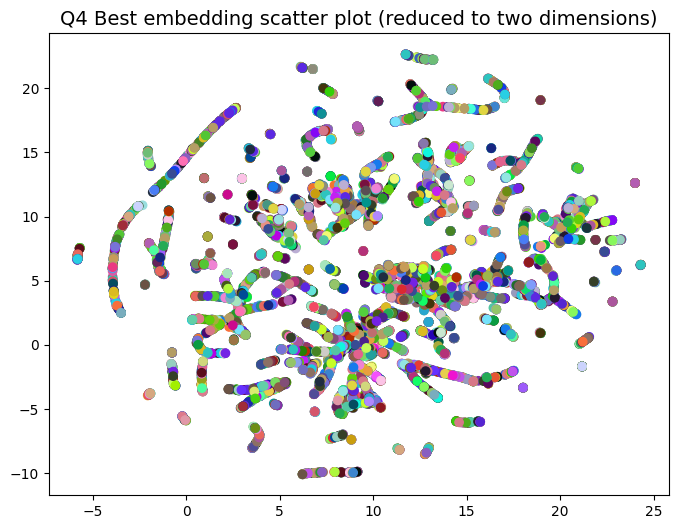

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(x = U_best[:,0], y = U_best[:,1], c = subgr.vs['color'], marker='o',label='Best Embedding')
plt.title('Q4 Best embedding scatter plot (reduced to two dimensions)', fontsize=14)

Text(0.5, 1.0, 'Q4 Worst embedding scatter plot (reduced to two dimensions)')

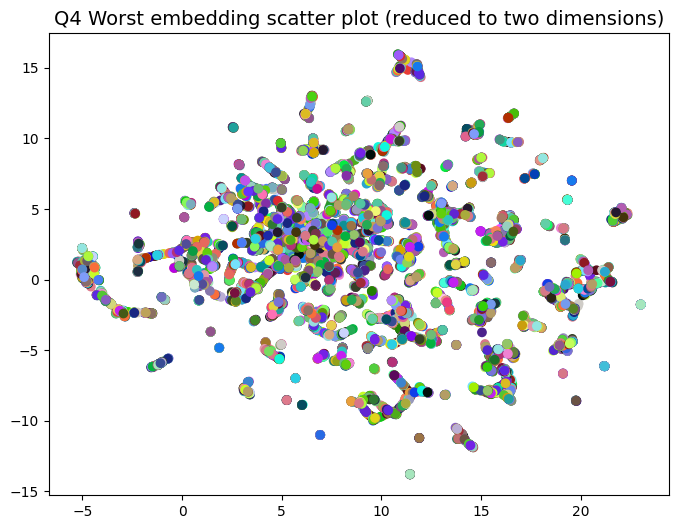

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(x = U_worst[:,0], y = U_worst[:,1], c = subgr.vs['color'], marker='o',label='Best Embedding')
plt.title('Q4 Worst embedding scatter plot (reduced to two dimensions)', fontsize=14)

# a) 

In [11]:
from random import randint

ecg = subgr.community_ecg()
num_clusters = np.max(ecg.membership)
print(f"Clusters: {num_clusters}")

subgr.write_edgelist("Q4.edgelist")

with open('Q4_colour.txt','w') as col_f, open("Q4_comm.ecg",'w') as comm_f:
    for node in subgr.vs:
        col_f.write(node['color'] + "\n")
        comm_f.write(str(node['gn']) + "\n")

Clusters: 218


In [12]:
ig.plot(subgr, bbox=(0,0,300,200)) #Doesn't work in jupyter, does in vscode

![title](Assignment4_Q4_a.PNG)

# b) #Compute embedded distance and geopgraphical distance

In [54]:
q4_best_embedding = readEmbedding(fn="Q4_HOPE_embeddings/_embed_dim=128")
indices = np.arange(len(q4_best_embedding))
df = pd.DataFrame(q4_best_embedding)
df["node"] = indices


In [29]:
from geopy import distance

subgr.vs[1].attributes()
sp = []
geo_dists = []
embed_dists = []
for edge in subgr.es:
    V_1 = edge.source_vertex
    V_2 = edge.target_vertex

    lat_1 = float(V_1["latitude"])
    lon_1 = float(V_1["longitude"])
    lat_2 = float(V_2["latitude"])
    lon_2 = float(V_2["longitude"])
    loc_1 = (lat_1, lon_1)
    loc_2 = (lat_2, lon_2)
    point_dist = distance.distance(loc_1, loc_2).km
    geo_dists.append(point_dist)

    a = np.array(df[df["node"] == int(V_1['name'])].drop("node", axis=1))
    b = np.array(df[df["node"] == int(V_2['name'])].drop("node", axis=1))    
    embed_dist = np.linalg.norm(a - b)
    embed_dists.append(embed_dist)    


Text(0, 0.5, 'Geographical distances')

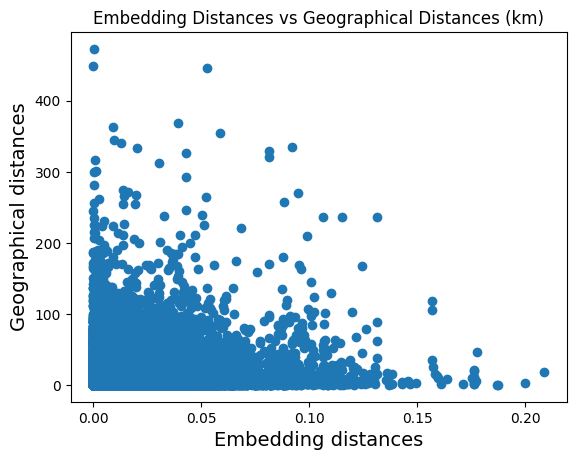

In [53]:
plt.scatter(embed_dists, geo_dists)
plt.title('Embedding Distances vs Geographical Distances (km)')
plt.xlabel('Embedding distances', fontsize=14)
plt.ylabel('Geographical distances', fontsize=14)

# c)

In [52]:
dist_df = pd.DataFrame({"embed_dist": embed_dists, "geo_dist": geo_dists})
dist_df = dist_df.sort_values(by="embed_dist", ascending=True)

min_dist = float(dist_df.head(1)["embed_dist"])
max_dist = float(dist_df.tail(1)["embed_dist"])

interval_size = (max_dist - min_dist)/10

buckets = list()
bucket_count = [0,0,0,0,0,0,0,0,0,0]
for dist in dist_df["embed_dist"]:
    bucket = int(np.floor((dist - min_dist)/interval_size))

    if bucket == 10:
        bucket_count[bucket-1] += 1
    else:
        bucket_count[bucket] += 1

    buckets.append(bucket)

print(bucket_count)

[12161, 2677, 1275, 390, 235, 134, 24, 11, 13, 2]


From our bucket count, we can conclude from our embedding space that most nodes on the electrical grid are close to each other, whcih matches what we would expect if we were to conduct a similar analysis on the geographical data.